In [2]:
!pip install kaggle


In [47]:
from google.colab import files
files.upload()

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.76G/5.76G [05:02<00:00, 20.0MB/s]
100% 5.76G/5.76G [05:02<00:00, 20.5MB/s]


In [12]:
!unzip cassava-leaf-disease-classification.zip

Archive:  cassava-leaf-disease-classification.zip
replace label_num_to_disease_map.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [41]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as display
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [9]:
csv_file_path = "/content/train.csv"
df = pd.read_csv(csv_file_path)


In [13]:
df['label'].value_counts()

label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64

In [14]:
print("DataFrame:")
print(df)


DataFrame:
             image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]


In [15]:
import json


json_file_path = "/content/label_num_to_disease_map.json"

# Read the JSON file
with open(json_file_path, 'r') as f:
    json_data = json.load(f)

#  Display the JSON data
print("JSON Data:")
print(json_data)


JSON Data:
{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


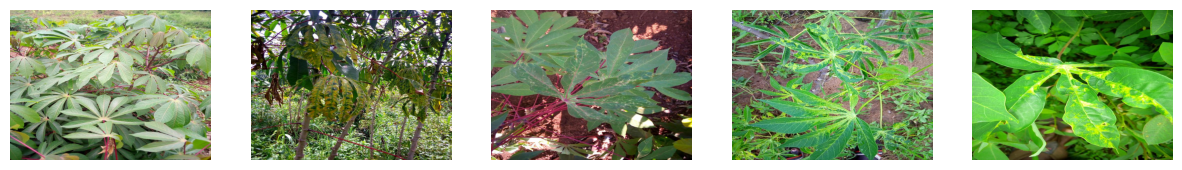

In [19]:

# Specify the path to the image directory
image_directory = '/content/train_images'

# List all files in the directory
image_files = os.listdir(image_directory)

#the number of images  to display
num_images_to_display = 5

# Create subplots
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

# Iterate over the selected number of images
for i in range(num_images_to_display):
    # Open the image
    image_path = os.path.join(image_directory, image_files[i])
    image = Image.open(image_path)

    # Display the image on the corresponding subplot
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axis labels

# Show the subplots
plt.show()

In [28]:
train_labels=df
df['label'] = df['label'].astype(str)


In [29]:
generator = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2
)


In [30]:
training_data = generator.flow_from_dataframe(
    df,
    directory = image_directory,
    batch_size = 16,
    target_size = (224, 224),
    subset = "training",
    seed = 128,
    x_col = "image_id",
    y_col = "label",
    class_mode = "categorical"
)

Found 17118 validated image filenames belonging to 5 classes.


In [31]:
validation_generator = ImageDataGenerator(
    validation_split = 0.2
)

validation_data =  validation_generator.flow_from_dataframe(
    df,
    directory = image_directory,
    batch_size = 16,
    target_size = (224, 224),
    subset = "validation",
    seed = 128,
    x_col = "image_id",
    y_col = "label",
    class_mode = "categorical"
)


Found 4279 validated image filenames belonging to 5 classes.


In [42]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg16_base.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [43]:
x = vgg16_base.output
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=vgg16_base.input, outputs=output)

In [38]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='softmax'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])




In [44]:

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [45]:
# Train the model
history = model.fit_generator(training_data,
    steps_per_epoch=len(training_data),
    epochs=10,
    validation_data = validation_data,
    validation_steps = len(validation_data)
)

Epoch 1/10


<ipython-input-45-7b6a4d0190f2>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_data,


1070/1070 [==============================] - 106s 93ms/step - loss: 0.9726 - accuracy: 0.6528 - val_loss: 0.8928 - val_accuracy: 0.6593
Epoch 2/10
1070/1070 [==============================] - 93s 86ms/step - loss: 0.8437 - accuracy: 0.6867 - val_loss: 0.8283 - val_accuracy: 0.6880
Epoch 3/10
1070/1070 [==============================] - 98s 91ms/step - loss: 0.8096 - accuracy: 0.6999 - val_loss: 0.8049 - val_accuracy: 0.7006
Epoch 4/10
1070/1070 [==============================] - 93s 87ms/step - loss: 0.7803 - accuracy: 0.7125 - val_loss: 0.7854 - val_accuracy: 0.7069
Epoch 5/10
1070/1070 [==============================] - 93s 87ms/step - loss: 0.7620 - accuracy: 0.7210 - val_loss: 0.7723 - val_accuracy: 0.7137
Epoch 6/10
1070/1070 [==============================] - 94s 87ms/step - loss: 0.7396 - accuracy: 0.7290 - val_loss: 0.7621 - val_accuracy: 0.7214
Epoch 7/10
1070/1070 [==============================] - 95s 88ms/step - loss: 0.7310 - accuracy: 0.7326 - val_loss: 0.7519 - val_accur

In [47]:

# Evaluate the model
loss, accuracy = model.evaluate(validation_data)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


268/268 [==============================] - 18s 69ms/step - loss: 0.7733 - accuracy: 0.7273
Test Loss: 0.773283064365387
Test Accuracy: 0.7272727489471436


Train images: 21397


{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


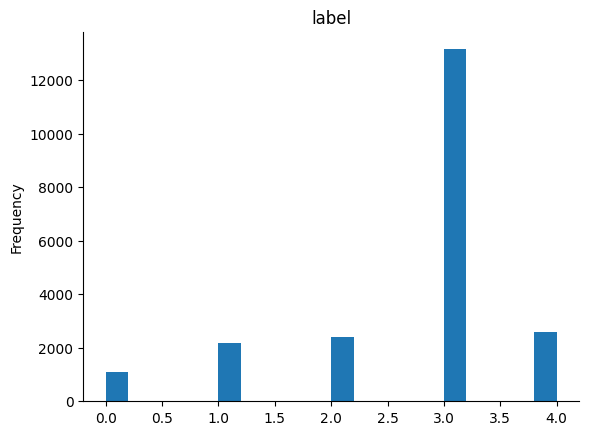

In [ ]:
from matplotlib import pyplot as plt
train_labels['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

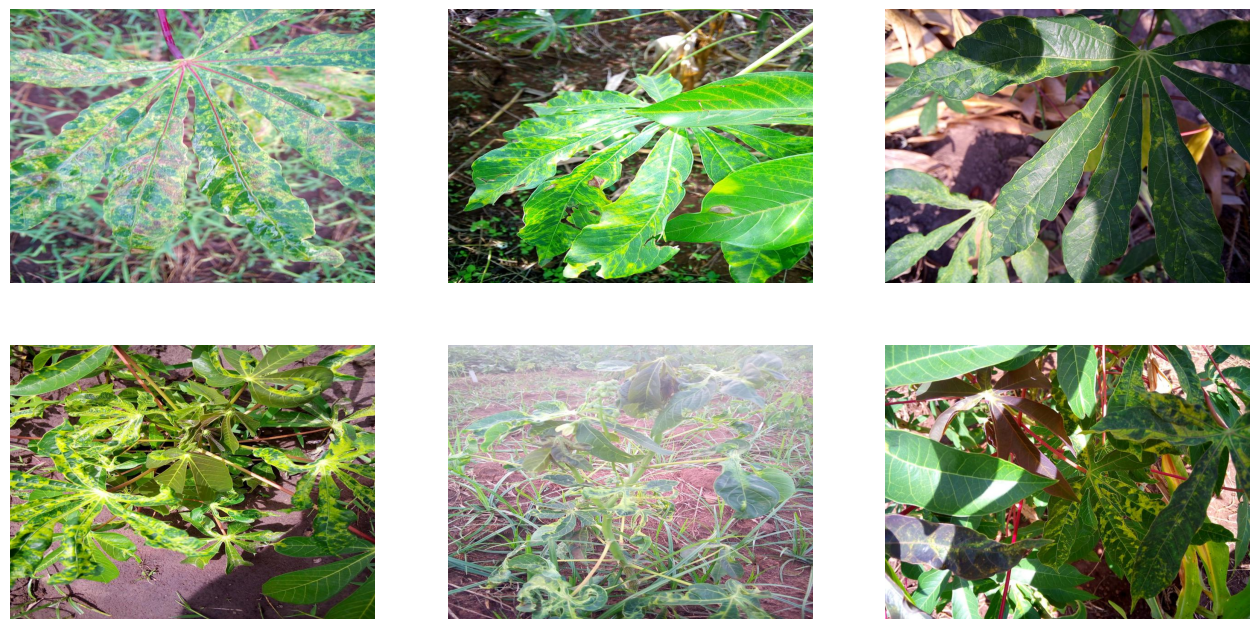

In [ ]:
sample = train_labels[train_labels.label == 3].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")

plt.show()

In [ ]:
np.round((df['label'].value_counts()/len(df['label']))*100, 2)

label
3    61.49
4    12.04
2    11.15
1    10.23
0     5.08
Name: count, dtype: float64

In [ ]:
len(df)

21397

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
df['label'] = df['label'].astype('str')
gen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2,
    rotation_range=20,      # Rotate images randomly by up to 20 degrees
    width_shift_range=0.1,  # Shift images horizontally by up to 10%
    height_shift_range=0.1, # Shift images vertically by up to 10%
    shear_range=0.2,        # Apply shear transformation with intensity up to 20%
    zoom_range=0.2,
    fill_mode='nearest'
)

train_datagen = gen.flow_from_dataframe(
    df,
    directory = os.path.join("/content/cassava-leaf-disease-classification/train_images"),
    batch_size = 64,
    target_size = (224, 224),
    subset = "training",
    seed = 42,
    x_col = "image_id",
    y_col = "label",
    class_mode = "categorical"
)

Found 17118 validated image filenames belonging to 5 classes.


In [ ]:
val_gen = ImageDataGenerator(
    validation_split = 0.2
)

val_datagen = val_gen.flow_from_dataframe(
    df,
    directory = os.path.join("/content/cassava-leaf-disease-classification/train_images"),
    batch_size = 64,
    target_size = (224, 224),
    subset = "validation",
    seed = 42,
    x_col = "image_id",
    y_col = "label",
    class_mode = "categorical"
)

Found 4279 validated image filenames belonging to 5 classes.


In [ ]:
len(train_datagen), len(val_datagen)

(268, 67)

In [ ]:
Steps_per_train = train_datagen.n / train_datagen.batch_size
Steps_per_val = val_datagen.n / val_datagen.batch_size

In [ ]:
Steps_per_train, Steps_per_val

(267.46875, 66.859375)

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Extract features using Xception



# Load the base xception model, explicitly specifying the input shape if not already defined
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = False

# Check the model structure to understand the output shape after Flatten
base_model.summary()

# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)
# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# Add a softmax layer with 3 output classes
prediction = Dense(5, activation='softmax')(x)

# Create a new model
xception_model = Model(inputs=base_model.input, outputs=prediction)
optimizer = Adam(learning_rate=0.0001)
# Compile the model
xception_model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [ ]:
history = xception_model.fit(
    train_datagen,
    steps_per_epoch = Steps_per_train,
    epochs = 10,
    validation_data = val_datagen,
    validation_steps = Steps_per_val
)

Epoch 1/10
 63/267 [======>.......................] - ETA: 3:11:53 - loss: 1.4153 - accuracy: 0.6062

In [ ]:
validation_loss, validation_accuracy = xception_model.evaluate(val_datagen)
print('Test accuracy:',validation_accuracy)

67/67 [==============================] - 20s 297ms/step - loss: 0.5822 - accuracy: 0.8229
Test accuracy: 0.8228558301925659


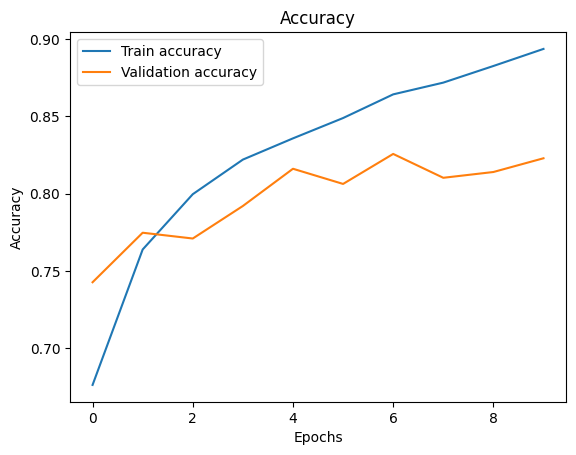

In [ ]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()
